# ADX + Supertrend Backtesting Notebook (Daily)

This notebook backtests a rules-based swing strategy that **combines Supertrend for direction** with **ADX as a trend-strength filter**. It evaluates performance per ticker (and a simple equal-weight aggregate), exports trade logs and summaries, and plots an equity curve.

### Strategy (from your brief)
- **Entry Long**: Supertrend flips **bearish→bullish** and **ADX ≥ threshold** (default 25)
- **Entry Short** *(optional)*: Supertrend flips **bullish→bearish** and **ADX ≥ threshold**
- **Exit**: Opposite flip (i.e., next entry in the other direction) or end of data

You can switch **long-only** or **long+short** in the config. Parameters (ATR period, multiplier, ADX period, threshold) are configurable.

**Note**: This backtest is intentionally simple and transparent—great for validation. You can later extend it with ATR stops, position sizing by volatility, and commission/slippage modeling.


In [9]:
# %pip install --upgrade yfinance pandas numpy pytz matplotlib

import pandas as pd
import numpy as np
import yfinance as yf
import pytz
import math
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
import matplotlib.pyplot as plt

IST = pytz.timezone('Asia/Kolkata')
pd.set_option('display.width', 180)
pd.set_option('display.max_columns', 100)


## 1) Configuration
Edit these values to match your universe and preferences.


In [10]:
TICKERS: List[str] = [
    'RELIANCE.NS','TCS.NS','HDFCBANK.NS','INFY.NS','ITC.NS'
]

# Data frequency
PERIOD   = '1y'     # more history for backtests
INTERVAL = '1d'     # daily swing strategy

# Indicator parameters (as per your PDF’s defaults)
ST_ATR_PERIOD = 10
ST_MULTIPLIER = 3.0
ADX_PERIOD    = 14
ADX_THRESHOLD = 25.0

# Backtest switches
LONG_ONLY      = True       # set False to allow long+short
RISK_PER_TRADE = 1.0        # placeholder for future sizing (not used in simple model)
TX_COST_BPS    = 0          # per-trade transaction cost in basis points (e.g., 5 = 0.05%)
SLIPPAGE_BPS   = 0          # per-trade slippage in basis points

# Output CSV paths
TRADES_CSV   = 'adx_supertrend_trades.csv'
SUMMARY_CSV  = 'adx_supertrend_summary.csv'


## 2) Indicators: Supertrend & ADX (pure Pandas/NumPy)
These match the implementations from the scanning notebook, using EMA (Wilder-like) smoothing.


In [11]:
def _ema_wilder_like(s: pd.Series, period: int) -> pd.Series:
    return s.ewm(span=period, adjust=False).mean()

def add_supertrend(df: pd.DataFrame, atr_period: int = 10, multiplier: float = 3.0) -> pd.DataFrame:
    df = df.copy()
    h, l, c = df['High'], df['Low'], df['Close']

    tr = pd.concat([(h - l), (h - c.shift(1)).abs(), (l - c.shift(1)).abs()], axis=1).max(axis=1)
    atr = _ema_wilder_like(tr, atr_period)

    hl2 = (h + l) / 2.0
    basic_ub = hl2 + multiplier * atr
    basic_lb = hl2 - multiplier * atr

    fub = pd.Series(index=df.index, dtype='float64')
    flb = pd.Series(index=df.index, dtype='float64')
    st  = pd.Series(index=df.index, dtype='float64')

    for i in range(len(df)):
        if i == 0:
            fub.iat[i] = basic_ub.iat[i]
            flb.iat[i] = basic_lb.iat[i]
            st.iat[i]  = np.nan
            continue
        prev_fub, prev_flb = fub.iat[i-1], flb.iat[i-1]
        # Final Upper/Lower bands
        fub.iat[i] = basic_ub.iat[i] if (basic_ub.iat[i] < prev_fub) or (c.iat[i-1] > prev_fub) else prev_fub
        flb.iat[i] = basic_lb.iat[i] if (basic_lb.iat[i] > prev_flb) or (c.iat[i-1] < prev_flb) else prev_flb
        # Supertrend flips
        if np.isnan(st.iat[i-1]):
            st.iat[i] = fub.iat[i] if c.iat[i] <= fub.iat[i] else flb.iat[i]
        else:
            if st.iat[i-1] == fub.iat[i-1]:
                st.iat[i] = fub.iat[i] if c.iat[i] <= fub.iat[i] else flb.iat[i]
            else:
                st.iat[i] = flb.iat[i] if c.iat[i] >= flb.iat[i] else fub.iat[i]

    df['ST'] = st
    df['ST_Trend'] = (df['Close'] > df['ST']).astype(int)
    return df

def add_adx(df: pd.DataFrame, period: int = 14) -> pd.DataFrame:
    df = df.copy()
    h, l, c = df['High'], df['Low'], df['Close']
    up_move, down_move = h.diff(), -l.diff()
    plus_dm  = pd.Series(np.where((up_move > down_move) & (up_move > 0), up_move, 0.0), index=df.index)
    minus_dm = pd.Series(np.where((down_move > up_move) & (down_move > 0), down_move, 0.0), index=df.index)
    tr = pd.concat([(h - l), (h - c.shift(1)).abs(), (l - c.shift(1)).abs()], axis=1).max(axis=1)
    atr = _ema_wilder_like(tr, period)
    sm_plus_dm  = _ema_wilder_like(plus_dm, period)
    sm_minus_dm = _ema_wilder_like(minus_dm, period)
    plus_di  = 100 * (sm_plus_dm / atr.replace(0, np.nan))
    minus_di = 100 * (sm_minus_dm / atr.replace(0, np.nan))
    dx  = 100 * ((plus_di - minus_di).abs() / (plus_di + minus_di).replace(0, np.nan))
    adx = _ema_wilder_like(dx, period)
    df['DI+'], df['DI-'], df['ADX'] = plus_di, minus_di, adx
    return df


## 3) Data Loading (yfinance)
We pull historical OHLCV and convert timestamps to **Asia/Kolkata** for clarity.


In [12]:
def fetch_history(ticker: str, period: str = PERIOD, interval: str = INTERVAL) -> pd.DataFrame:
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=False, progress=False, multi_level_index=False)
    if df is None or df.empty:
        return pd.DataFrame()
    if df.index.tz is None:
        df.index = df.index.tz_localize('UTC').tz_convert(IST)
    else:
        df.index = df.index.tz_convert(IST)
    return df


## 4) Signal generation (flip + ADX filter)
Signals are checked **bar-close**, with fills assumed at the **next open**.


In [13]:
def compute_signals(df: pd.DataFrame, adx_threshold: float) -> pd.DataFrame:
    df = df.copy()
    df['FlipUp']   = (df['ST_Trend'].shift(1) == 0) & (df['ST_Trend'] == 1)
    df['FlipDown'] = (df['ST_Trend'].shift(1) == 1) & (df['ST_Trend'] == 0)
    df['Strong']   = df['ADX'] >= adx_threshold
    df['SigLong']  = df['FlipUp'] & df['Strong']
    df['SigShort'] = df['FlipDown'] & df['Strong']
    return df


## 5) Backtest Engine
Simple, readable loop: enter on next open when a signal appears; exit on opposite signal’s next open or on the last bar. Returns per-trade log and equity curve.


In [14]:
@dataclass
class Trade:
    ticker: str
    side: str           # 'LONG' or 'SHORT'
    entry_time: pd.Timestamp
    entry_px: float
    exit_time: pd.Timestamp
    exit_px: float
    ret: float          # simple return (not annualized)

def backtest_one(df: pd.DataFrame, ticker: str, allow_short: bool, tx_bps: int = 0, slippage_bps: int = 0) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if df.empty:
        return pd.DataFrame(), pd.DataFrame()
    # Ensure required cols
    for col in ['Open','High','Low','Close','ST_Trend','SigLong','SigShort']:
        if col not in df.columns:
            raise ValueError(f"Missing column {col} for {ticker}")

    trades: List[Trade] = []
    position = None  # None / ('LONG', entry_time, entry_px) or ('SHORT', ...)
    equity = [1.0]   # start capital per ticker = 1.0
    eq_time = [df.index[0]]

    cost = (tx_bps + slippage_bps) / 10000.0

    for i in range(1, len(df)):
        t_prev, t_now = df.index[i-1], df.index[i]
        row_prev, row = df.iloc[i-1], df.iloc[i]

        # Next open fill assumptions
        entry_px = row['Open'] * (1 + cost)
        exit_px  = row['Open'] * (1 - cost)

        if position is None:
            if row_prev['SigLong']:
                position = ('LONG', t_now, entry_px)
            elif (not LONG_ONLY) and allow_short and row_prev['SigShort']:
                position = ('SHORT', t_now, entry_px)
        else:
            side, ent_t, ent_px = position
            # Exit on opposite signal
            if side == 'LONG' and row_prev['SigShort']:
                r = (exit_px - ent_px) / ent_px
                trades.append(Trade(ticker,'LONG',ent_t,ent_px,t_now,exit_px,float(r)))
                equity.append(equity[-1] * (1.0 + r))
                eq_time.append(t_now)
                position = None
            elif side == 'SHORT' and row_prev['SigLong']:
                r = (ent_px - exit_px) / ent_px
                trades.append(Trade(ticker,'SHORT',ent_t,ent_px,t_now,exit_px,float(r)))
                equity.append(equity[-1] * (1.0 + r))
                eq_time.append(t_now)
                position = None

    # Close any open trade at last bar close
    if position is not None:
        side, ent_t, ent_px = position
        last_t = df.index[-1]
        last_px = df.iloc[-1]['Close'] * (1 - cost)
        if side == 'LONG':
            r = (last_px - ent_px) / ent_px
            trades.append(Trade(ticker,'LONG',ent_t,ent_px,last_t,last_px,float(r)))
        else:
            r = (ent_px - last_px) / ent_px
            trades.append(Trade(ticker,'SHORT',ent_t,ent_px,last_t,last_px,float(r)))
        equity.append(equity[-1] * (1.0 + r))
        eq_time.append(last_t)

    trades_df = pd.DataFrame([t.__dict__ for t in trades])
    eq_df = pd.DataFrame({'Time': eq_time, 'Equity': equity}).set_index('Time')
    return trades_df, eq_df

def perf_metrics(trades: pd.DataFrame, equity: pd.Series) -> Dict[str, float]:
    res = {k: np.nan for k in ['TotalReturn','CAGR','Sharpe','Sortino','MaxDD','WinRate','NumTrades','AvgTrade','ProfitFactor']}
    if equity is None or equity.empty:
        return res
    total_ret = equity.iloc[-1] - 1.0
    # CAGR
    years = (equity.index[-1] - equity.index[0]).days / 365.25
    cagr = (equity.iloc[-1]) ** (1/years) - 1 if years > 0 else np.nan
    # Daily returns from equity (log or simple). Use simple here.
    er = equity.pct_change().dropna()
    if not er.empty:
        sharpe = np.sqrt(252) * (er.mean() / (er.std() + 1e-12))
        downside = er[er < 0]
        sortino = np.sqrt(252) * (er.mean() / (downside.std() + 1e-12))
        # Max drawdown
        roll_max = (equity).cummax()
        dd = (equity / roll_max) - 1.0
        maxdd = dd.min()
    else:
        sharpe = np.nan; sortino = np.nan; maxdd = np.nan
    # Trade stats
    if trades is not None and not trades.empty:
        nr = len(trades)
        wins = (trades['ret'] > 0).mean()
        avg = trades['ret'].mean()
        gross_profit = trades.loc[trades['ret'] > 0, 'ret'].sum()
        gross_loss   = -trades.loc[trades['ret'] < 0, 'ret'].sum()
        pf = (gross_profit / gross_loss) if gross_loss > 0 else np.nan
    else:
        nr = 0; wins = np.nan; avg = np.nan; pf = np.nan
    res.update({
        'TotalReturn': float(total_ret),
        'CAGR': float(cagr) if cagr is not None else np.nan,
        'Sharpe': float(sharpe),
        'Sortino': float(sortino),
        'MaxDD': float(maxdd),
        'WinRate': float(wins),
        'NumTrades': int(nr),
        'AvgTrade': float(avg) if avg is not None else np.nan,
        'ProfitFactor': float(pf) if pf is not None else np.nan,
    })
    return res


## 6) Run Backtest (per ticker) and Aggregate
We compute indicators → signals → simulate trades per ticker; then summarize and export CSVs.


In [15]:
all_trades = []
summ_rows  = []
agg_equities = []

for t in TICKERS:
    try:
        raw = fetch_history(t)
        if raw.empty or len(raw) < max(ST_ATR_PERIOD, ADX_PERIOD) + 50:
            print(f"[SKIP] {t}: insufficient data")
            continue
        df = add_supertrend(raw, ST_ATR_PERIOD, ST_MULTIPLIER)
        df = add_adx(df, ADX_PERIOD)
        df = compute_signals(df, ADX_THRESHOLD)
        trades_df, eq_df = backtest_one(df, t, allow_short=(not LONG_ONLY), tx_bps=TX_COST_BPS, slippage_bps=SLIPPAGE_BPS)
        if not trades_df.empty:
            all_trades.append(trades_df)
        # Fill forward equity to full index for clean aggregation
        if not eq_df.empty:
            eq_full = eq_df.reindex(df.index).ffill()
            eq_full.columns = [t]
            agg_equities.append(eq_full)
            m = perf_metrics(trades_df, eq_full[t])
            m.update({'Ticker': t})
            summ_rows.append(m)
    except Exception as e:
        print(f"[ERROR] {t}: {e}")

trades_all = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame(columns=['ticker','side','entry_time','entry_px','exit_time','exit_px','ret'])
summary_df = pd.DataFrame(summ_rows).set_index('Ticker') if summ_rows else pd.DataFrame()

# Aggregate equity: equal-weight (mean of per-ticker equities)
if agg_equities:
    eq_cat = pd.concat(agg_equities, axis=1).dropna()
    eq_mean = eq_cat.mean(axis=1)
else:
    eq_cat = pd.DataFrame(); eq_mean = pd.Series(dtype=float)

display(summary_df.sort_values('CAGR', ascending=False))
display(trades_all.head(20))

trades_all.to_csv(TRADES_CSV, index=False)
summary_df.to_csv(SUMMARY_CSV)
print(f"Saved trades to: {TRADES_CSV}\nSaved summary to: {SUMMARY_CSV}")


,TotalReturn,CAGR,Sharpe,Sortino,MaxDD,WinRate,NumTrades,AvgTrade,ProfitFactor
Ticker,,,,,,,,,
HDFCBANK.NS,0.084941,0.085245,0.716691,NaN,-0.042596,0.666667,3,0.029610,3.085427
TCS.NS,-0.086678,-0.086962,-1.121526,-0.131226,-0.086678,0.000000,3,-0.029140,0.000000
ITC.NS,-0.114852,-0.115223,-1.098330,-0.109401,-0.114852,0.000000,2,-0.057965,0.000000
RELIANCE.NS,-0.143360,-0.143815,-0.694518,-0.499267,-0.237822,0.250000,4,-0.033845,0.477937
INFY.NS,-0.217947,-0.218607,-1.295355,-0.173063,-0.217947,0.000000,3,-0.076051,0.000000


,ticker,side,entry_time,entry_px,exit_time,exit_px,ret
0,RELIANCE.NS,LONG,2024-09-30 05:30:00+05:30,1519.400024,2024-10-04 05:30:00+05:30,1403.925049,-0.076000
1,RELIANCE.NS,LONG,2024-12-04 05:30:00+05:30,1326.000000,2024-12-20 05:30:00+05:30,1224.000000,-0.076923
2,RELIANCE.NS,LONG,2025-01-09 05:30:00+05:30,1267.000000,2025-04-07 05:30:00+05:30,1132.199951,-0.106393
3,RELIANCE.NS,LONG,2025-04-21 05:30:00+05:30,1270.000000,2025-07-22 05:30:00+05:30,1427.400024,0.123937
4,TCS.NS,LONG,2024-11-12 05:30:00+05:30,4216.000000,2024-12-23 05:30:00+05:30,4200.049805,-0.003783
5,TCS.NS,LONG,2025-03-26 05:30:00+05:30,3647.750000,2025-04-04 05:30:00+05:30,3362.600098,-0.078171
6,TCS.NS,LONG,2025-08-26 05:30:00+05:30,3129.000000,2025-09-15 05:30:00+05:30,3111.899902,-0.005465
7,HDFCBANK.NS,LONG,2024-09-23 05:30:00+05:30,874.500000,2024-10-04 05:30:00+05:30,837.250000,-0.042596
8,HDFCBANK.NS,LONG,2024-10-25 05:30:00+05:30,877.500000,2024-12-23 05:30:00+05:30,891.000000,0.015385
9,HDFCBANK.NS,LONG,2025-02-05 05:30:00+05:30,866.500000,2025-09-15 05:30:00+05:30,967.049988,0.116042


Saved trades to: adx_supertrend_trades.csv
Saved summary to: adx_supertrend_summary.csv


## 7) Plot Aggregate Equity Curve
Single-plot Matplotlib chart (no explicit colors per instructions).

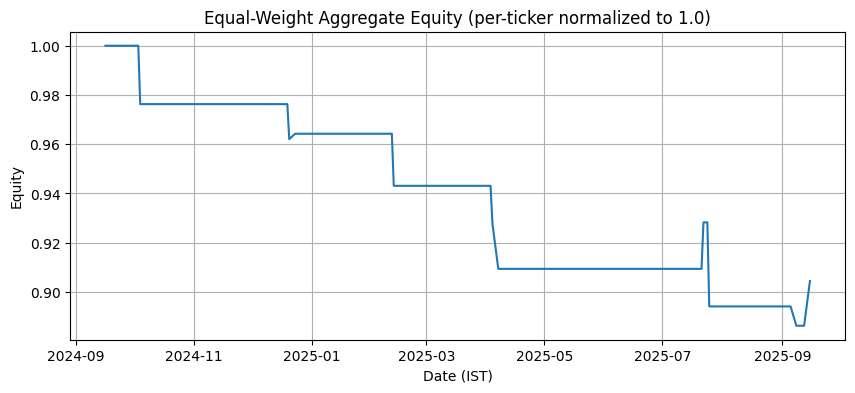

In [16]:
if not eq_mean.empty:
    plt.figure(figsize=(10,4))
    plt.plot(eq_mean.index, eq_mean.values)
    plt.title('Equal-Weight Aggregate Equity (per-ticker normalized to 1.0)')
    plt.xlabel('Date (IST)')
    plt.ylabel('Equity')
    plt.grid(True)
    plt.show()
else:
    print('No equity curves to plot (insufficient data or all tickers skipped).')


## 8) Notes & Extensions
- Add **ATR-based position sizing** (risk parity) and **commission/slippage** realism.
- Add **stop-loss** / **trailing stop** using Supertrend or ATR multiples.
- Parameter sweeps (grid search) and **walk-forward** validation.
- Multi-timeframe alignment (e.g., weekly trend filter with daily entries).

This notebook follows the same rules presented in your strategy document (Supertrend flips + ADX filter).